In [60]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
from glob import glob
from tqdm import tqdm
from IPython.display import display, HTML

from plotly.offline import iplot
#to link plotly to pandas
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline = False, world_readable = True)

import gc

import warnings
warnings.simplefilter('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, average_precision_score
from sklearn.metrics import precision_recall_curve, auc

plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams['axes.titlesize'] = 12
sns.set_palette('Set3')

In [61]:
col = ["#9DC183", "#2A8EA6", "#F1C232", "#ECECEC", "#FF7F50"]
sns.set_palette(sns.color_palette(col))

In [62]:
SEED = 42
def seed_everything(seed = SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)

In [265]:
input_files = glob("./data/parsed_output/*.tsv")
print(f"Num of training files: {len(input_files)}")
input_files[:10]

Num of training files: 81


['./data/parsed_output/Valvata_tricarinata_parsed.tsv',
 './data/parsed_output/Conus_coccineus_parsed.tsv',
 './data/parsed_output/Vitrinula_chaunax_parsed.tsv',
 './data/parsed_output/Desbruyeresia_costata_parsed.tsv',
 './data/parsed_output/Conus_parvatus_parsed.tsv',
 './data/parsed_output/Pleurobema_cordatum_parsed.tsv',
 './data/parsed_output/Thoanteus_gibber_parsed.tsv',
 './data/parsed_output/Fusconaia_mitchelli_parsed.tsv',
 './data/parsed_output/Lamellidens_jenkinsianus_parsed.tsv',
 './data/parsed_output/Valvata_stenotrema_parsed.tsv']

In [140]:
header = ["year", "class", "order", "family", "genus", "scientific_name", "latitude", "longitude", "elevation", "depth",
          "taxon_key", "n_native", "n_pres", "n_vagabond", "n_class", "n_order", "n_family", "n_genus", "iucn_status", "max_temp", "min_temp", "mean_temp", "prec_sum_mean"]
len(header)

23

In [142]:
df_all = pd.read_csv("./data/01-All_Mollusca_parsed.tsv", names=header, sep="\t", index_col=False)
# df_all.drop(exclude, axis=1, inplace=True)
print(df_all.shape)
df_all.head()

(1220, 23)


,year,class,order,family,genus,scientific_name,latitude,longitude,elevation,depth,...,n_vagabond,n_class,n_order,n_family,n_genus,iucn_status,max_temp,min_temp,mean_temp,prec_sum_mean
0,1914,Gastropoda,Stylommatophora,Achatinellidae,Achatinella,Achatinella pupukanioe,NaN,NaN,NaN,NaN,...,0,1213,399,11,7,CR,NaN,NaN,NaN,NaN
1,1931,Gastropoda,Stylommatophora,Achatinellidae,Achatinella,Achatinella pupukanioe,NaN,NaN,NaN,NaN,...,0,1213,399,11,7,CR,NaN,NaN,NaN,NaN
2,1933,Gastropoda,Stylommatophora,Achatinellidae,Achatinella,Achatinella pupukanioe,NaN,NaN,NaN,NaN,...,0,1213,399,11,7,CR,NaN,NaN,NaN,NaN
3,1934,Gastropoda,Stylommatophora,Achatinellidae,Achatinella,Achatinella pupukanioe,NaN,NaN,NaN,NaN,...,0,1213,399,11,7,CR,NaN,NaN,NaN,NaN
4,1936,Gastropoda,Stylommatophora,Achatinellidae,Achatinella,Achatinella pupukanioe,21.405552,-157.882181,NaN,NaN,...,0,1213,399,11,7,CR,NaN,NaN,NaN,NaN


In [145]:
# Check a single txt file
temp = pd.read_csv(np.random.choice(input_files, 1)[0], sep="\t", names=header, index_col=False).melt(id_vars="year").sort_values(by="year")
temp.head()

,year,variable,value
0,1966,class,Gastropoda
66,1966,genus,Lepetodrilus
88,1966,scientific_name,Lepetodrilus pustulosus
110,1966,latitude,0.788333
132,1966,longitude,-86.13


In [154]:
pid = temp[temp['variable'] == 'scientific_name']['value'].values[0]
target = temp[temp['variable'] == 'iucn_status']['value'].values[0]

print(f"{pid}: {target}")

def plot_parameters(df: pd.DataFrame, pid: float, target: int):
    color = ['red', 'green', 'orange', 'blue']
    for i, p in enumerate(['mean_temp', 'n_genus']):
        temp = df[['year', 'value']][df['variable'] == p]
        if not temp.empty:
            df[['year', 'value']][df['variable'] == p].iplot(kind = 'line', 
                                                               x = 'year', 
                                                               y = 'value', 
                                                               xTitle = 'Time',
                                                               yTitle = p,
                                                               title = f'<b>Parameter: {p}; RecordID: {pid}; Mortality: {target}</b>',
                                                               color = col[i])

Lepetodrilus pustulosus: NT


In [155]:
plot_parameters(temp, pid, target)

### Check number of Timepoints

<Axes: ylabel='count'>

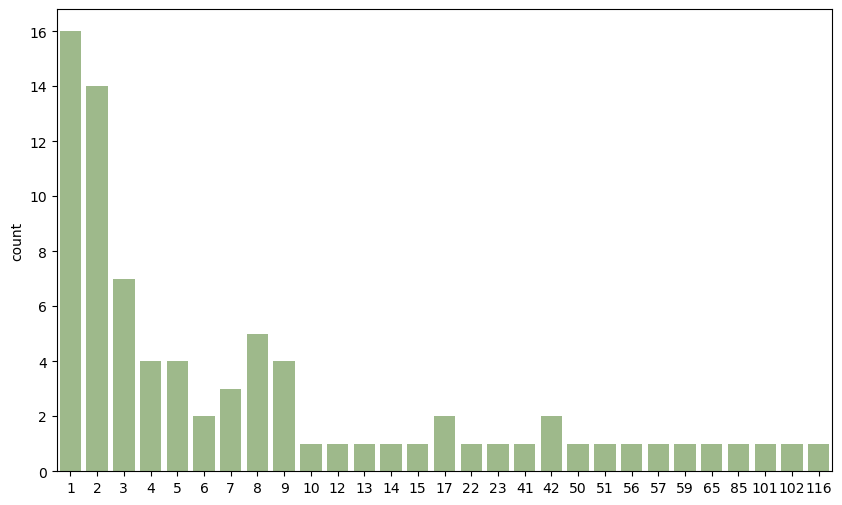

In [174]:
species_dict = {}
for sp in df_all['scientific_name']:
    if sp not in species_dict:
        species_dict[sp] = 1
    else:
        species_dict[sp] += 1

plt.figure(figsize=(10,6))
sns.countplot(x = list(species_dict.values()), color=col[0])

In [251]:
num_feat = ["depth", "n_native", "n_pres", "n_vagabond", "n_class", "n_order", "n_family", "n_genus", "max_temp",
              "elevation", "min_temp", "mean_temp", "prec_sum_mean"]
cat_feat = ["class", "order", "iucn_status"]

In [254]:
def extract_to_dict(df: pd.DataFrame, num_feat: list, cat_feat: list) -> pd.DataFrame:
    patient_dict = {"scientific_name": df['scientific_name'][0]}
    for feat in num_feat:
        df_melted = df.melt(id_vars="year").sort_values(by="year")
        patient_dict[feat] = round(df_melted[df_melted['variable'] == feat]['value'].mean(), 2)
    for feat in cat_feat:
        df_sorted = df.sort_values(by="year")
        patient_dict[feat] = df_sorted[feat].iloc[-1]
    return pd.DataFrame(patient_dict, index = [0])

In [267]:
df = pd.DataFrame()

for file in tqdm(input_files):
    temp = pd.read_csv(file, sep="\t", names=header, index_col=False)
    df = df.append(extract_to_dict(temp, num_feat=num_feat, cat_feat=cat_feat))
print(df.shape)
len(set(df['scientific_name']))

100%|██████████| 81/81 [00:00<00:00, 88.39it/s]

(81, 17)


81

In [268]:
df.to_csv("./data.csv")

## Preprocessing

In [269]:

# Missing values plot
missing = df.isna().sum().reset_index()
missing.columns = ['features', 'total_missing']
missing['percent'] = (missing['total_missing'] / len(df)) * 100
missing.index = missing['features']
del missing['features']

missing['total_missing'].iplot(kind = 'bar', 
                               title = f'<b>Missing Values Count in Dataset</b>',
                               xTitle = 'Features',
                               colors = 'blue',
                               yTitle = 'Count')
missing.T

features,scientific_name,depth,n_native,n_pres,n_vagabond,n_class,n_order,n_family,n_genus,max_temp,elevation,min_temp,mean_temp,prec_sum_mean,class,order,iucn_status
total_missing,0.0,65.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17.000000,64.000000,17.000000,17.000000,17.000000,0.0,7.000000,0.0
percent,0.0,80.246914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20.987654,79.012346,20.987654,20.987654,20.987654,0.0,8.641975,0.0


In [270]:
df['iucn_status'].value_counts()

LC       40
NT       11
VU       10
EN        6
CR        5
LR/nt     4
LR/cd     2
DD        1
EX        1
EW        1
Name: iucn_status, dtype: int64

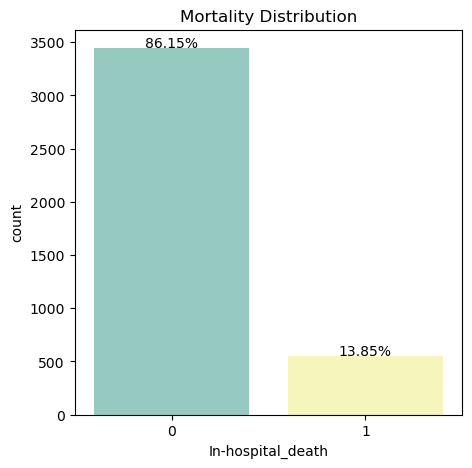

In [106]:
plt.figure(figsize = (5, 5))
ax = sns.countplot(df, x='In-hospital_death')
plt.title('Mortality Distribution')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

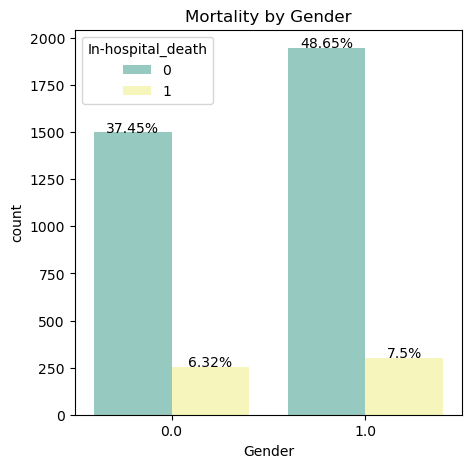

In [107]:
plt.figure(figsize = (5, 5))
plt.title('Mortality by Gender')
ax = sns.countplot(x = 'Gender', data = df, hue = 'In-hospital_death')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

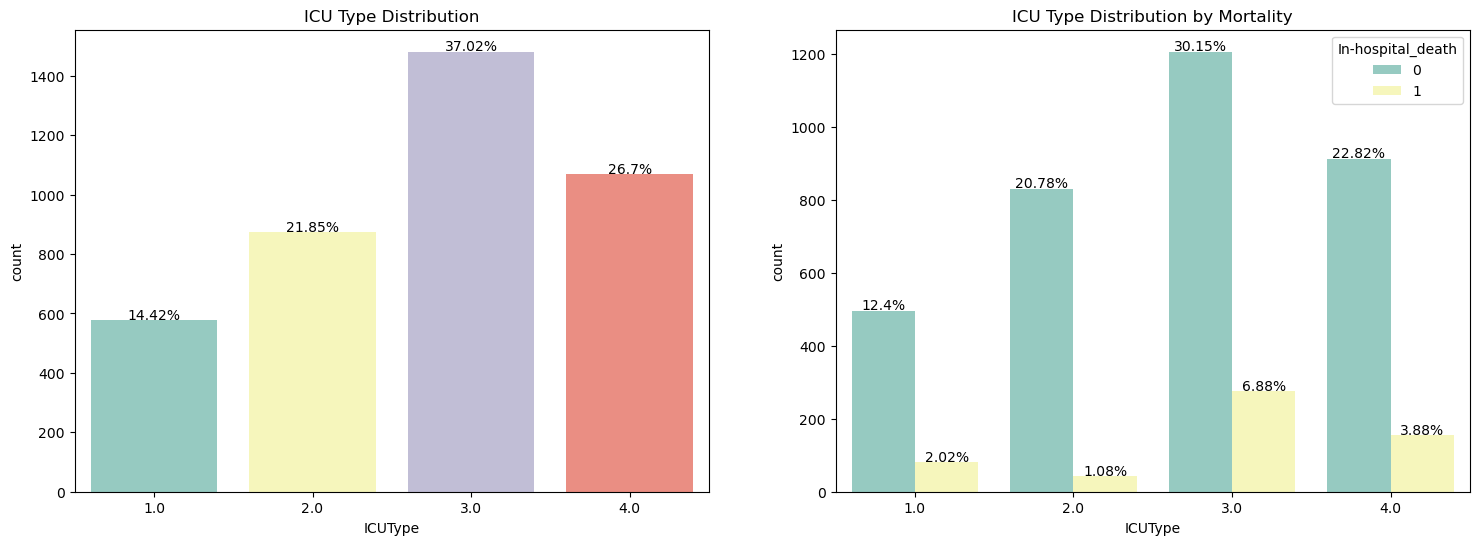

In [108]:
plt.figure(figsize = (18, 6))
plt.subplot(1, 2, 1)
plt.title('ICU Type Distribution')
ax = sns.countplot(x = 'ICUType', data = df)
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')
        
plt.subplot(1, 2, 2)
plt.title('ICU Type Distribution by Mortality')
ax = sns.countplot(x = 'ICUType', data = df, hue = 'In-hospital_death')
for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
                f"{round(100 * height / len(df), 2)}%",
                ha = 'center')

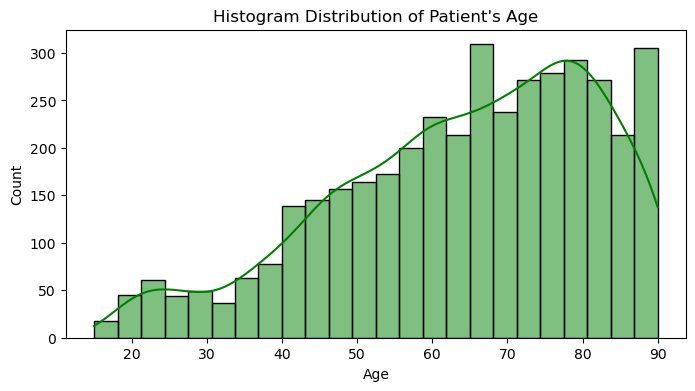

In [109]:
plt.figure(figsize = (8, 4))
plt.title("Histogram Distribution of Patient's Age")
sns.histplot(df['Age'], color = 'green', kde = True);

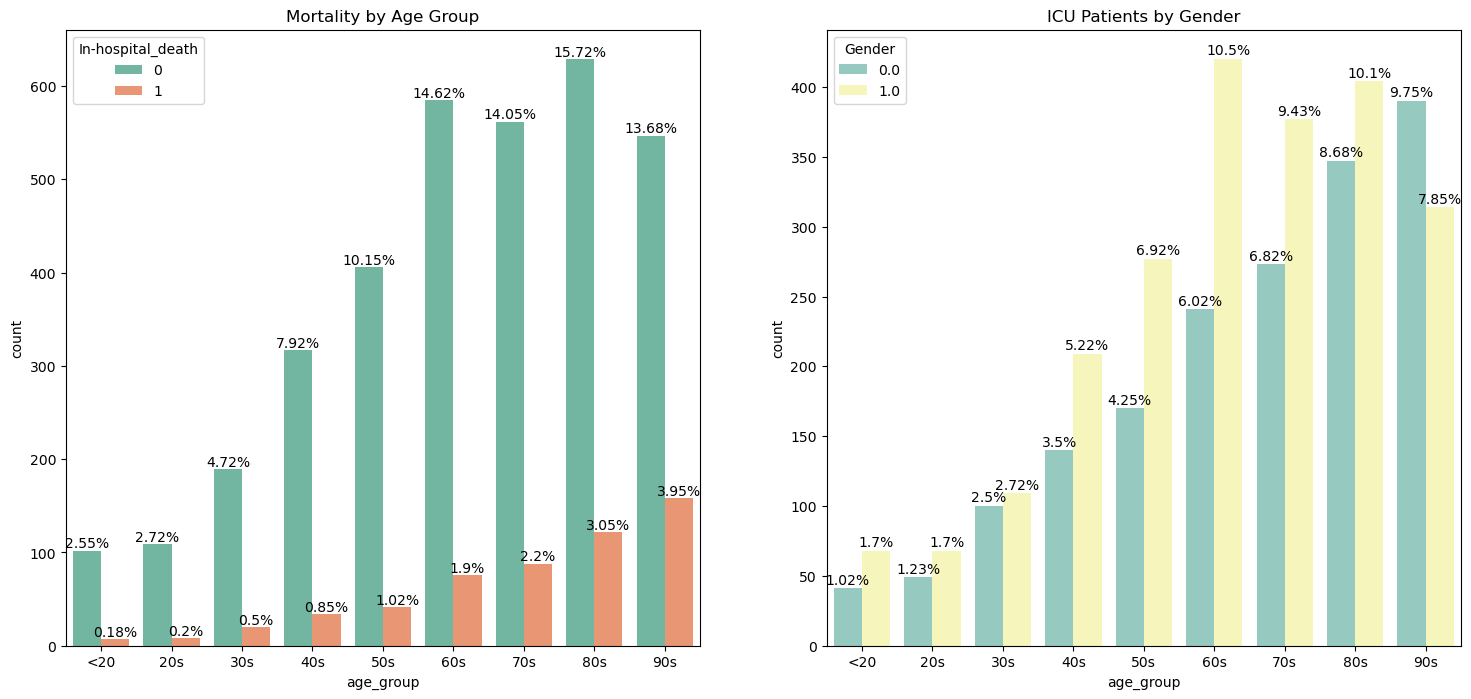

In [110]:
df['age_group'] = pd.cut(df['Age'], bins = 9, labels = ['<20', '20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s'])

plt.figure(figsize = (18, 8))
plt.subplot(1, 2, 1)
plt.title('Mortality by Age Group')
ax = sns.countplot(x = 'age_group', data = df, hue = 'In-hospital_death', palette = 'Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

plt.subplot(1, 2, 2)
plt.title('ICU Patients by Gender')
ax = sns.countplot(x = 'age_group', data = df, hue = 'Gender', palette = 'Set3')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

In [111]:
df['Height'] = df['Height'].fillna(df['Height'].median())
df['Weight'] = df['Weight'].fillna(df['Weight'].median())
df['bmi'] = df.apply(lambda x: round((x['Weight'] / (x['Height'] ** 2)) * 10000, 2), axis = 1)
df['bmi_group'] = pd.cut(df['bmi'], bins = [df['bmi'].min(), 18.5, 24.9, 29.9, df['bmi'].max()], labels = ['Underweight', 'Healthy', 'Overweight', 'Obesity'])

del df['bmi']
gc.collect()

25626

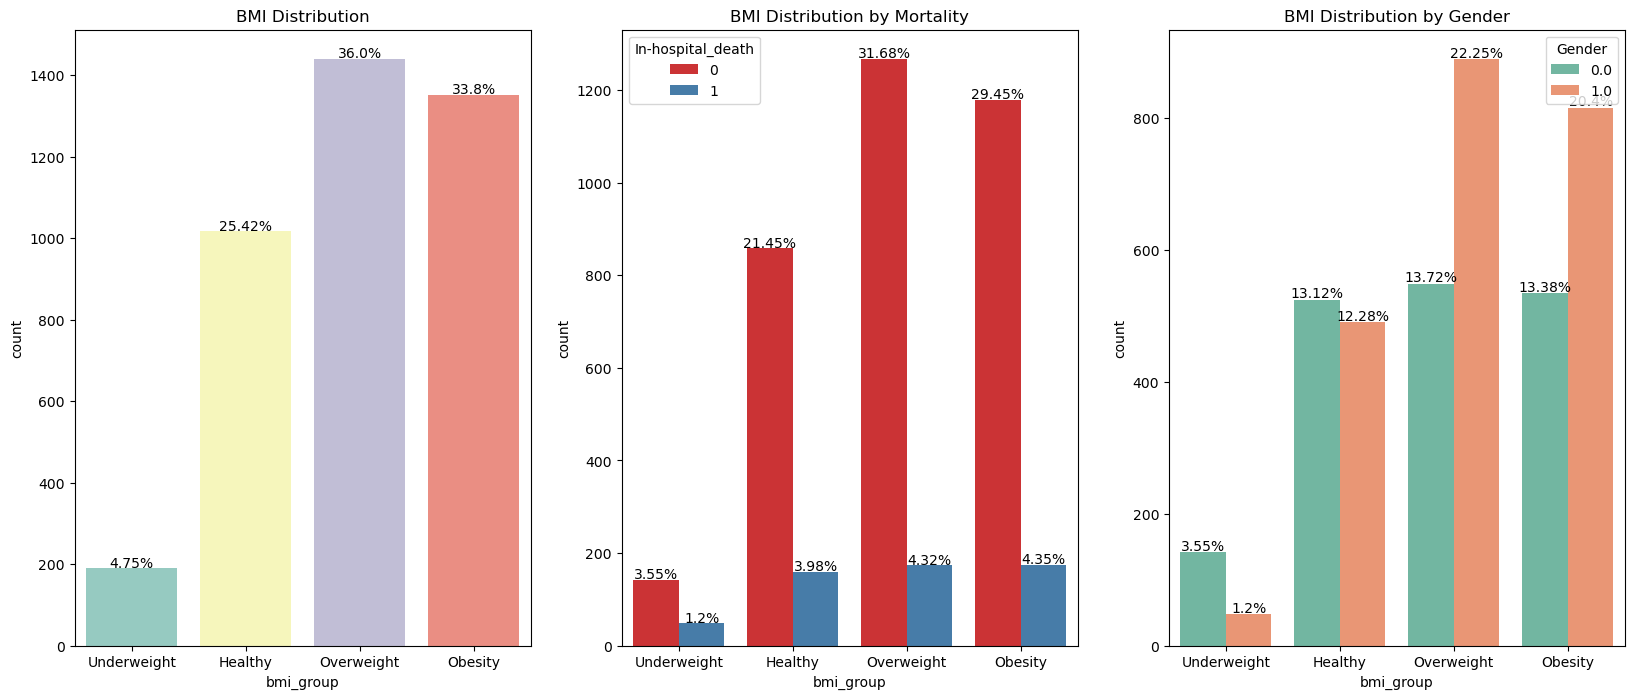

In [115]:
plt.figure(figsize = (20, 8))
plt.subplot(1, 3, 1)
plt.title('BMI Distribution')
ax = sns.countplot(df, x='bmi_group')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

plt.subplot(1, 3, 2)
plt.title('BMI Distribution by Mortality')
ax = sns.countplot(x = 'bmi_group', data = df, hue = 'In-hospital_death', palette = 'Set1')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

plt.subplot(1, 3, 3)
plt.title('BMI Distribution by Gender')
ax = sns.countplot(x = 'bmi_group', data = df, hue = 'Gender', palette = 'Set2')
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2.0, height + 3,
            f"{round(100 * height / len(df), 2)}%",
            ha = 'center')

In [116]:
cat_features = ['Gender', 'ICUType', 'age_group', 'bmi_group']
num_features = [c for c in df.columns if c not in cat_features]
num_features = [c for c in num_features if c not in ['RecordID', 'In-hospital_death']]
cat_features, num_features

(['Gender', 'ICUType', 'age_group', 'bmi_group'],
 ['Age',
  'Height',
  'Weight',
  'Urine',
  'HR',
  'Temp',
  'NIDiasABP',
  'SysABP',
  'DiasABP',
  'pH',
  'PaCO2',
  'PaO2',
  'Platelets',
  'MAP',
  'K',
  'Na',
  'FiO2',
  'GCS'])

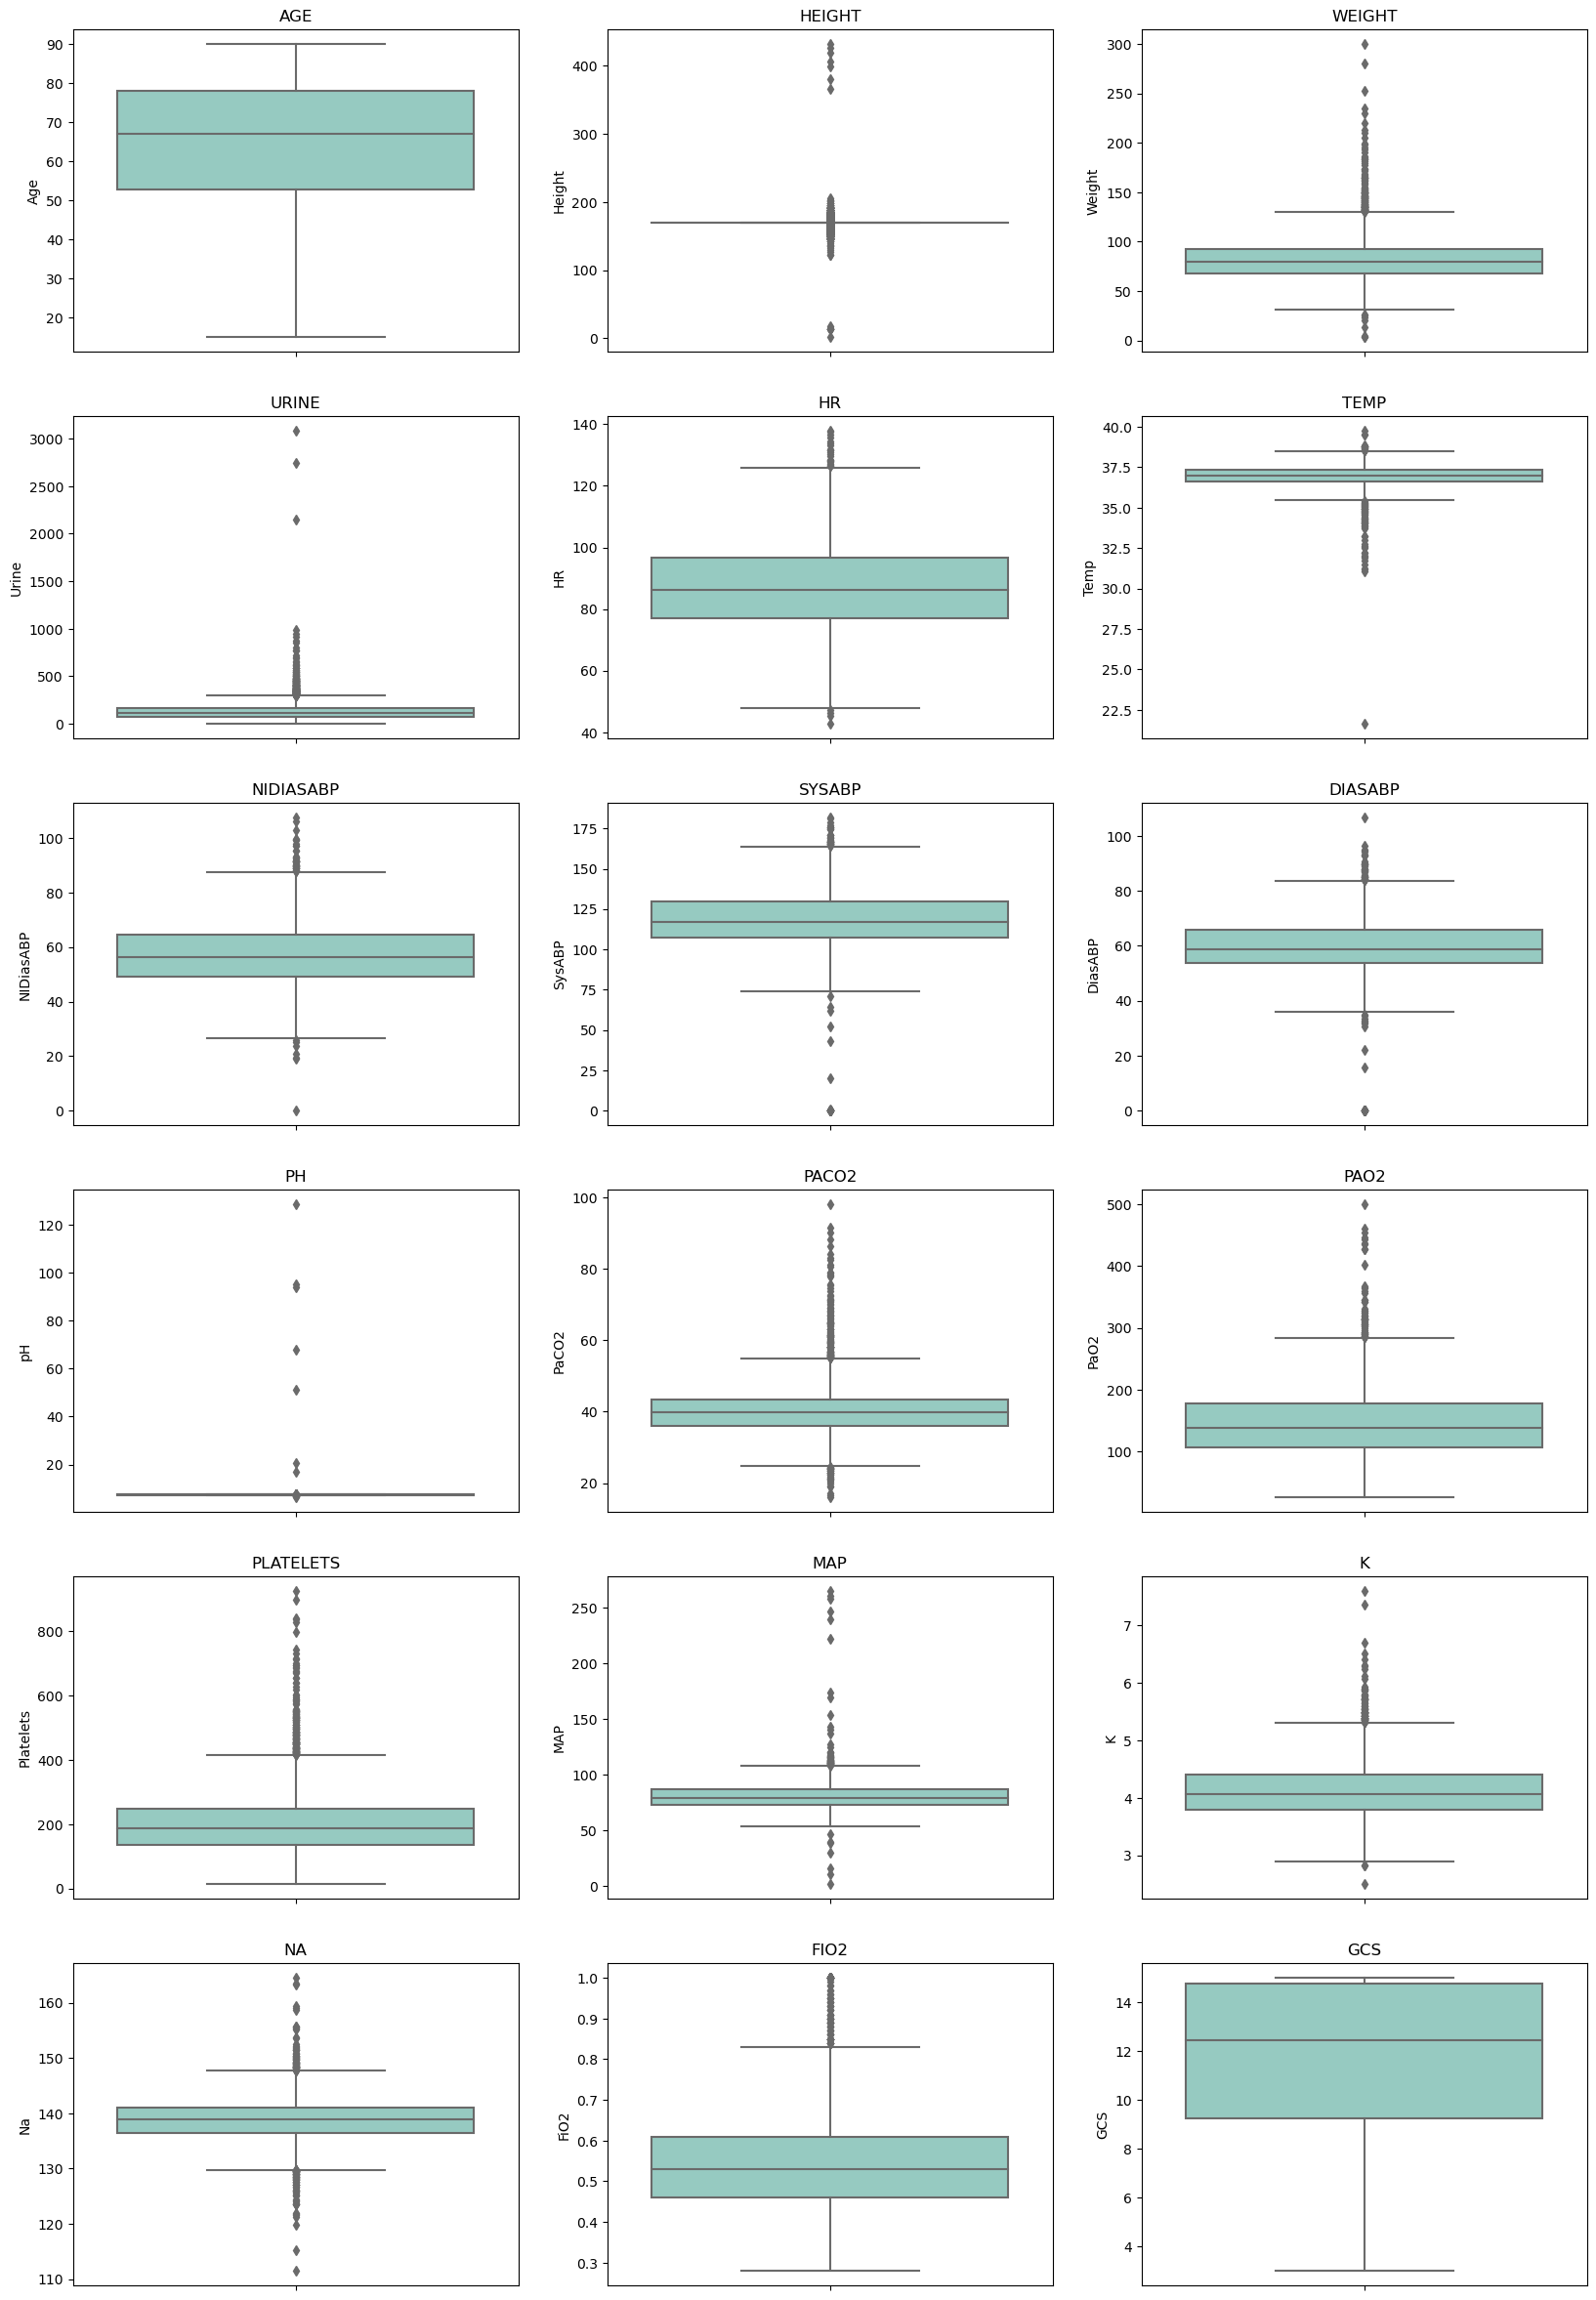

In [120]:
plt.figure(figsize = (20, 30))
for i, col in enumerate(df[num_features]):
    plt.subplot(6, int(len(num_features) / 6), i + 1)
    sns.boxplot(y = col, data = df)
    plt.title(col.upper())

In [121]:
# NaN imputation
df_0 = df[df['In-hospital_death'] == 0].copy()
df_1 = df[df['In-hospital_death'] == 1].copy()
#Impute Numerical Features with mean value
df_0[num_features] = df_0[num_features].fillna(df_0[num_features].mean())
df_1[num_features] = df_1[num_features].fillna(df_1[num_features].mean())

#Impute Categorical Features with most frequent value
for col in cat_features:
    df_0[col] = df_0[col].fillna(df_0[col].value_counts().index[0])
    df_1[col] = df_1[col].fillna(df_1[col].value_counts().index[0])

#concat both df, shuffle and reset index
df = pd.concat([df_0, df_1], axis = 0).sample(frac = 1).reset_index(drop = True)

In [122]:
print('Feature Correlation with target:')
df.corr()['In-hospital_death']

Feature Correlation with target:


RecordID            -0.011532
Age                  0.130700
Gender              -0.015298
Height              -0.013628
Weight              -0.054590
Urine               -0.124613
HR                   0.073804
Temp                -0.060056
NIDiasABP           -0.092159
SysABP              -0.066522
DiasABP             -0.075262
pH                   0.027729
PaCO2               -0.095989
PaO2                -0.100565
Platelets           -0.021218
MAP                 -0.032993
K                    0.022343
Na                   0.022402
FiO2                 0.052448
GCS                 -0.256607
ICUType              0.059896
In-hospital_death    1.000000
Name: In-hospital_death, dtype: float64

In [126]:
#Label Encoding age, gender, category
for col in ['Gender', 'ICUType', 'age_group', 'bmi_group']:
    print(f"Label Encoding: {col} - {df[col].nunique()}")
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

Label Encoding: Gender - 2
Label Encoding: ICUType - 4
Label Encoding: age_group - 9
Label Encoding: bmi_group - 4


In [127]:
std = StandardScaler()
df[num_features] = std.fit_transform(df[num_features])

In [128]:
X = df.drop(['RecordID', 'In-hospital_death'], axis = 1)
y = df['In-hospital_death'].copy()

In [130]:
#scale_pos_weight - sample Weights
num_pos_samples = y.value_counts().values[1]
num_neg_samples = y.value_counts().values[0]

class_weight = num_neg_samples / num_pos_samples
print(f"scale_pos_weight:")
num_neg_samples / num_pos_samples, np.sqrt(num_neg_samples / num_pos_samples)

scale_pos_weight:


(6.2202166064981945, 2.4940362079364835)

## Models 

In [141]:
# Plots

def plot_pr_curve(precision, recall, avg_precision):
    plt.figure(figsize = (8, 6))
    plt.plot(recall, precision, label = f"Avg. PR: {round(avg_precision, 2)}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.5, 1.05])
    plt.xlim([0.55, 1.0])
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

def plot_confusion(mat):
    plt.figure(figsize = (8, 4))
    sns.heatmap(pd.DataFrame(mat), annot = True, annot_kws = {"size": 25}, cmap = 'Blues', fmt = 'g')
    plt.title('Confusion matrix', y = 1.1, fontsize = 22)
    plt.ylabel('Actual', fontsize = 18)
    plt.xlabel('Predicted', fontsize = 18)
    plt.show()

def compute_precision_recall(conf_mat):
    #compute precision and recall
    tp_and_fn = conf_mat.sum(axis = 1)
    tp_and_fp = conf_mat.sum(axis = 0)
    tp = conf_mat.diagonal()
    precision = tp / tp_and_fp
    recall = tp / tp_and_fn
    return precision, recall

In [131]:
# XGB
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance

xgb_params = {
         'objective': 'binary:logistic',
         'lambda': 0.0030282073258141168, 
         'alpha': 0.01563845128469084,
         'colsample_bytree': 0.55,
         'subsample': 0.7,
         'learning_rate': 0.01,
         'max_depth': 9,
         'random_state': 2020, 
         'min_child_weight': 257,
         'eval_metric': 'aucpr',
         'seed': 2021,
         'scale_pos_weight': num_neg_samples / num_pos_samples #np.sqrt(num_neg_samples / num_pos_samples)
         }

In [134]:
n_folds = 10
preds_xg = []
overall_pr = []
all_precision, all_recall = [], []

skf = StratifiedKFold(n_splits = n_folds)
#rkf = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 5, random_state = 42)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [136]:
model_type = 'xgbclassifier'

###########################################################################################
Fold: 1
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


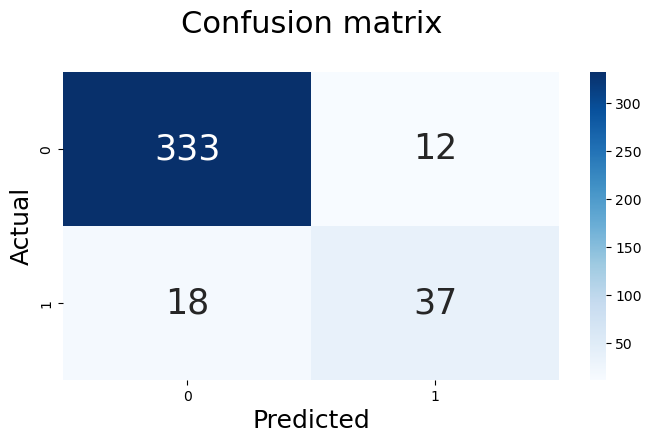


Avg. Precision-Recall Score: 0.8208786394014677
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       345
           1       0.76      0.67      0.71        55

    accuracy                           0.93       400
   macro avg       0.85      0.82      0.83       400
weighted avg       0.92      0.93      0.92       400

###########################################################################################
Fold: 2
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


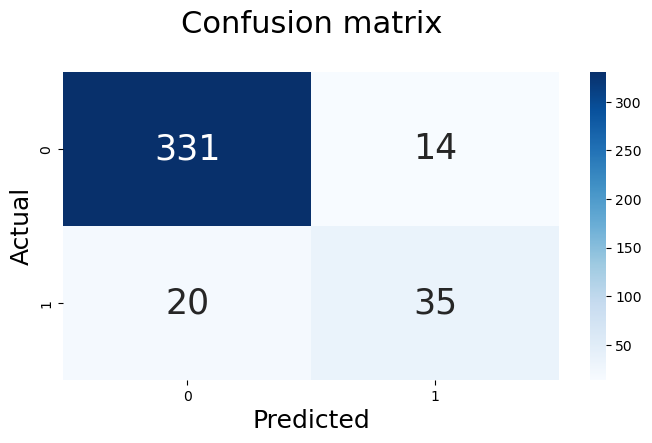


Avg. Precision-Recall Score: 0.7807822512634142
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       345
           1       0.71      0.64      0.67        55

    accuracy                           0.92       400
   macro avg       0.83      0.80      0.81       400
weighted avg       0.91      0.92      0.91       400

###########################################################################################
Fold: 3
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


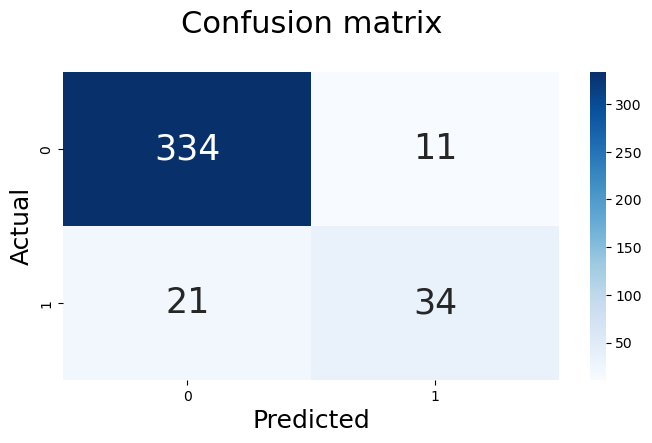


Avg. Precision-Recall Score: 0.8068388698981721
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       345
           1       0.76      0.62      0.68        55

    accuracy                           0.92       400
   macro avg       0.85      0.79      0.82       400
weighted avg       0.92      0.92      0.92       400

###########################################################################################
Fold: 4
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


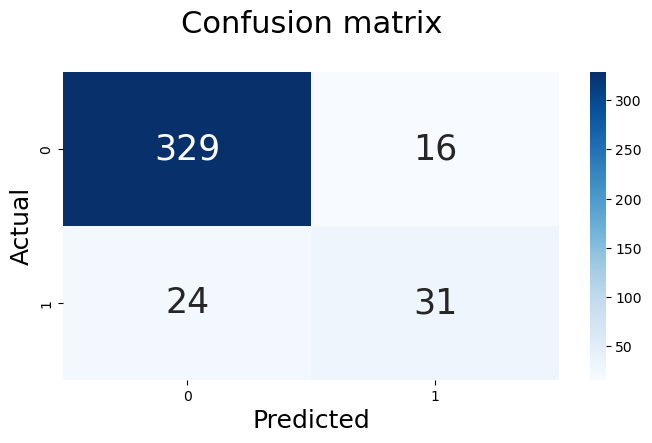


Avg. Precision-Recall Score: 0.73229906948942
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       345
           1       0.66      0.56      0.61        55

    accuracy                           0.90       400
   macro avg       0.80      0.76      0.78       400
weighted avg       0.89      0.90      0.90       400

###########################################################################################
Fold: 5
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


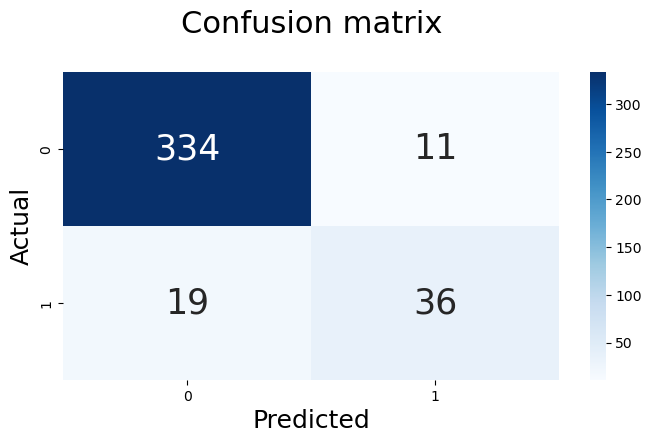


Avg. Precision-Recall Score: 0.8109998405348675
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       345
           1       0.77      0.65      0.71        55

    accuracy                           0.93       400
   macro avg       0.86      0.81      0.83       400
weighted avg       0.92      0.93      0.92       400

###########################################################################################
Fold: 6
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


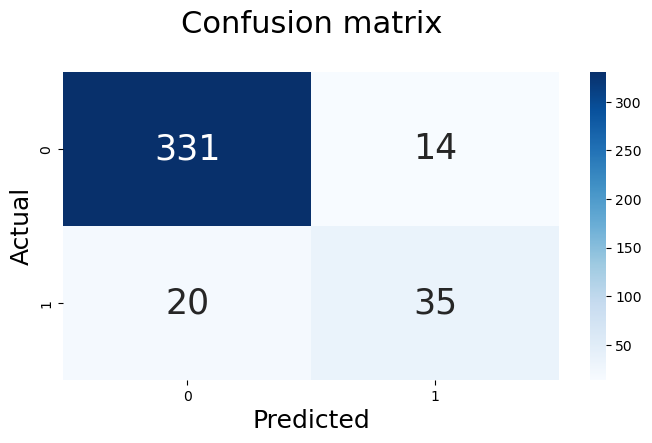


Avg. Precision-Recall Score: 0.8043192081236057
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       345
           1       0.71      0.64      0.67        55

    accuracy                           0.92       400
   macro avg       0.83      0.80      0.81       400
weighted avg       0.91      0.92      0.91       400

###########################################################################################
Fold: 7
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


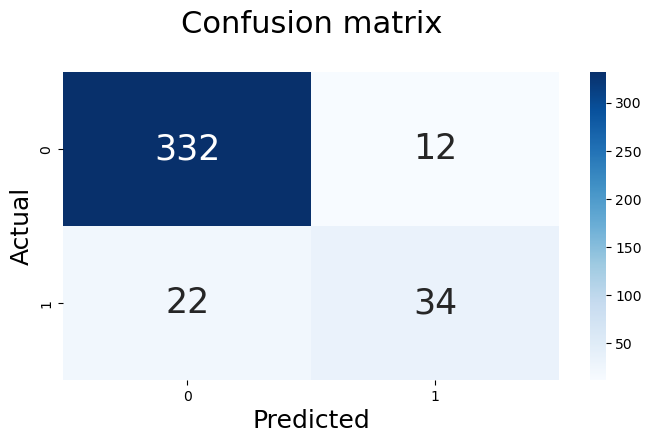


Avg. Precision-Recall Score: 0.768628120753543
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       344
           1       0.74      0.61      0.67        56

    accuracy                           0.92       400
   macro avg       0.84      0.79      0.81       400
weighted avg       0.91      0.92      0.91       400

###########################################################################################
Fold: 8
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


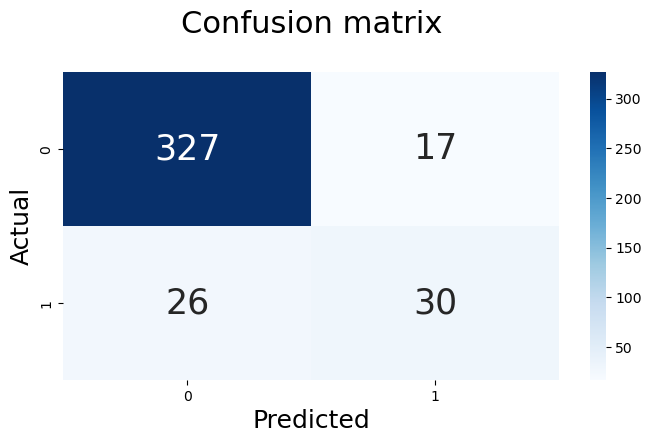


Avg. Precision-Recall Score: 0.7624644486947645
Classification Report: 
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       344
           1       0.64      0.54      0.58        56

    accuracy                           0.89       400
   macro avg       0.78      0.74      0.76       400
weighted avg       0.89      0.89      0.89       400

###########################################################################################
Fold: 9
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


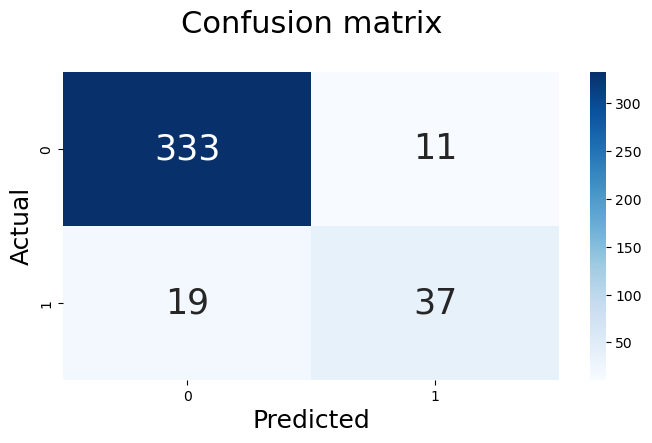


Avg. Precision-Recall Score: 0.8136708986699439
Classification Report: 
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       344
           1       0.77      0.66      0.71        56

    accuracy                           0.93       400
   macro avg       0.86      0.81      0.83       400
weighted avg       0.92      0.93      0.92       400

###########################################################################################
Fold: 10
(3600, 22) (3600,) (400, 22) (400,)
Classifier: xgbclassifier
###########################################################################################


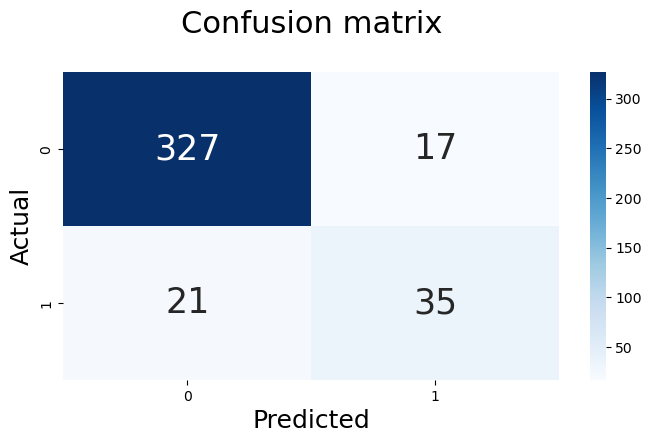


Avg. Precision-Recall Score: 0.793557870239267
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       344
           1       0.67      0.62      0.65        56

    accuracy                           0.91       400
   macro avg       0.81      0.79      0.80       400
weighted avg       0.90      0.91      0.90       400



In [142]:
for i, (trn_idx, val_idx) in enumerate(skf.split(X, y)):
    print('#############' * 7)
    print(f"Fold: {i + 1}")
    Xtrain, ytrain = X.iloc[trn_idx], y[trn_idx]
    Xvalid, yvalid = X.iloc[val_idx], y[val_idx]
    print(Xtrain.shape, ytrain.shape, Xvalid.shape, yvalid.shape)
    print(f"Classifier: {model_type}")
    print('#############' * 7)

    if model_type == 'xgboost':
        xg_train = xgb.DMatrix(Xtrain, label = ytrain)
        xg_valid = xgb.DMatrix(Xvalid, label = yvalid)

        clf = xgb.train(params,
                          xg_train,
                          5000,
                          verbose_eval = 50,
                          evals = [(xg_train, 'train'), (xg_valid, 'valid')],
                          early_stopping_rounds = 100
                       )

        valid_preds = clf.predict(xg_valid)

    if model_type == 'xgbclassifier':
        clf = XGBClassifier(scale_pos_weight = class_weight, eval_metric = 'aucpr',
                                random_state = 42, n_jobs = -1)
        clf.fit(Xtrain, ytrain)
        valid_preds = clf.predict_proba(Xvalid)[:, 1]
    
    conf_mat = confusion_matrix(yvalid, valid_preds > 0.5)
    #compute precision and recall
    pre, rec = compute_precision_recall(conf_mat)
    all_precision.append(pre)
    all_recall.append(rec)
    plot_confusion(conf_mat)
        
    avg_precision = average_precision_score(yvalid, valid_preds)
    print(f'\nAvg. Precision-Recall Score: {avg_precision}')
    overall_pr.append(avg_precision)

    print(f"Classification Report: \n{classification_report(yvalid, valid_preds > 0.5, labels = [0, 1])}")

In [143]:
print(f"Overall Avg CV Score: {np.mean(overall_pr)}")
print(f"Avg. Precision: {np.mean(all_precision)}\nAvg. Recall: {np.mean(all_recall)}")

Overall Avg CV Score: 0.7894439217068465
Avg. Precision: 0.8294882996742713
Avg. Recall: 0.7909302489724633


## SHAP

In [144]:
import shap

#Shap values with XGBoost core model
#Getting the shap values using the model is faster than usual way
booster_xgb = clf.get_booster()
shap_values_xgb = booster_xgb.predict(xgb.DMatrix(Xtrain, ytrain), pred_contribs = True)


In [145]:
shap_values_xgb = shap_values_xgb[:, :-1]
print(shap_values_xgb.shape)
pd.DataFrame(shap_values_xgb, columns = Xtrain.columns.tolist()).head()

(3600, 22)


,Age,Gender,Height,Weight,Urine,HR,Temp,NIDiasABP,SysABP,DiasABP,...,PaO2,Platelets,MAP,K,Na,FiO2,GCS,ICUType,age_group,bmi_group
0,-0.055017,0.003271,-0.042210,-0.582848,-1.024530,-0.344752,-0.593058,-2.468422,-0.714952,-0.314656,...,-0.694202,0.194424,0.166040,-0.130699,-0.420083,-0.419248,-1.425243,-0.697049,-0.005561,0.017523
1,-0.159547,0.053895,0.013675,-0.137008,-1.145523,-0.098676,0.732405,-0.319058,-0.768668,-0.200797,...,0.094891,-0.348375,0.087801,0.027039,0.041899,-2.731508,-1.798326,0.095273,-0.030167,-0.153623
2,0.212855,0.033612,-0.078169,-0.465862,-0.887387,-0.476534,-0.382532,-2.087696,-0.623535,-0.280812,...,-0.115227,-0.423181,-0.312522,-0.067071,-0.023734,-0.763139,-1.105336,0.212697,-0.009897,0.088062
3,-2.012266,-0.172425,0.001280,-0.307363,-0.957352,0.962614,-0.355171,-1.113436,-0.901904,-0.296779,...,-0.471105,-0.109371,-0.234325,-0.364457,-0.055649,-0.216443,-1.721030,0.134935,-0.003825,0.015961
4,-2.523887,-0.067473,-0.511645,-0.211538,-0.575456,0.498033,-0.431216,-0.138139,-0.494639,-0.360800,...,-0.182179,-0.449902,-0.063417,-0.100013,-0.830994,-0.405454,2.955504,0.106174,0.037929,0.052328


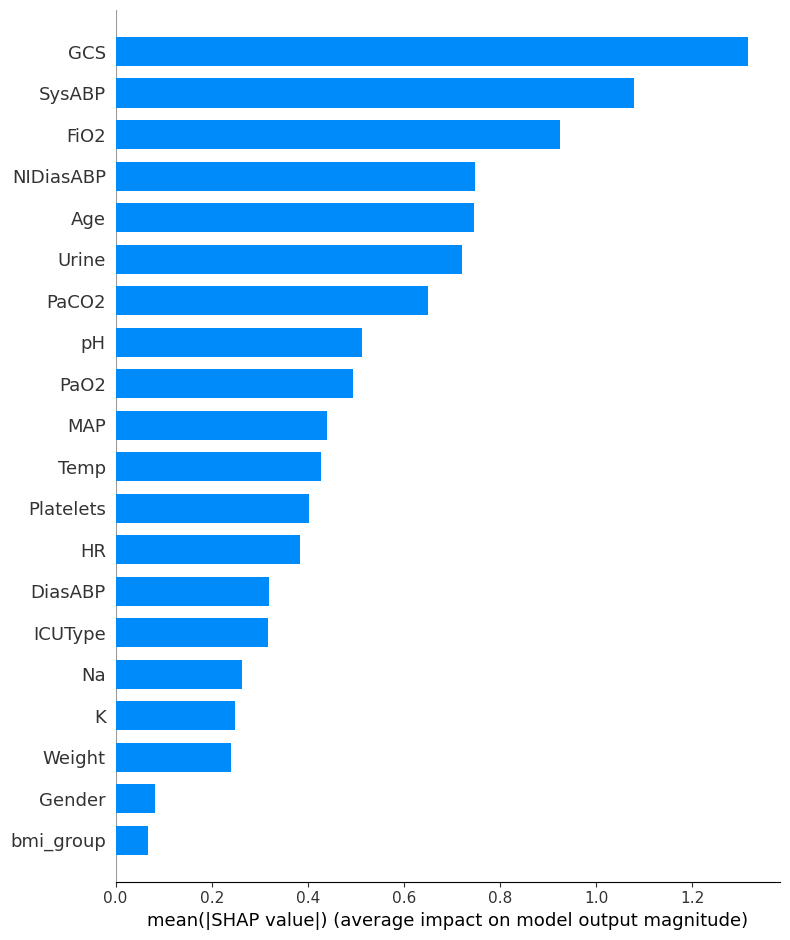

In [150]:
shap.summary_plot(shap_values_xgb, Xtrain, feature_names = Xtrain.columns, plot_type = "bar")

In [151]:
#importances are just the average absolute Shapley values for a feature. We can check that below:
pd.DataFrame(shap_values_xgb, columns = Xtrain.columns)["GCS"].abs().mean()

1.3163271

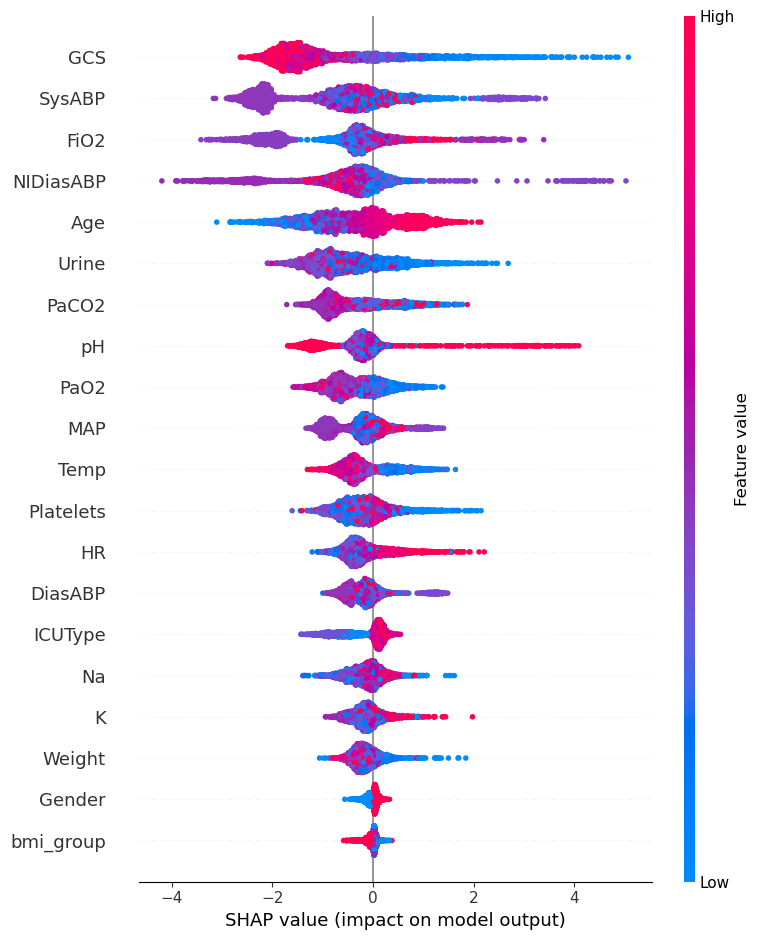

In [152]:
shap.summary_plot(shap_values_xgb, Xtrain, feature_names = Xtrain.columns);